In [4]:

from collections import Counter, defaultdict
import pickle
import os
import re

'''
This script analyzes all the extracted entities from time-series files based on legislation period and year.
"TPT/Entities" structures are created with the script find_time_series_entities.py
'''

'\nThis script analyzes all the extracted entities from time-series files based on legislation period and year.\n"TPT/Entities" structures are created with the script find_time_series_entities.py\n'

In [5]:
ENTITY_ROOT = "TPT/Entities"

# Step 1: Traverse all entity subfolders
grouped_entities = defaultdict(list)

for root, dirs, files in os.walk(ENTITY_ROOT):
    for file in files:
        if file.endswith(".pkl"):
            file_path = os.path.join(root, file)
            period_year = os.path.basename(root).replace("_txts", "")  # e.g. d27-y3
            try:
                with open(file_path, "rb") as f:
                    entities = pickle.load(f)
                    grouped_entities[period_year].extend(entities)
            except Exception as e:
                print(f"❌ Failed to load {file_path}: {e}")

In [6]:
# Helper to extract (dönem, yıl) as sortable integers
def parse_period_year(name):
    match = re.match(r'd(\d+)-y(\d+)', name)
    if match:
        return int(match.group(1)), int(match.group(2))
    return float("inf"), float("inf")  # push malformed folders to the end

In [7]:
# Helper to recombine subwords
def recombine_subwords(entities):
    merged = []
    current = None

    for ent in entities:
        word = ent["word"]

        if word.startswith("##") and current:
            current["word"] += word[2:]
            current["end"] = ent["end"]
        else:
            if current:
                merged.append(current)
            current = ent.copy()

    if current:
        merged.append(current)

    return merged

In [8]:
# Step 2: Sort keys chronologically (dönem then yıl)
sorted_keys = sorted(grouped_entities.keys(), key=parse_period_year)

In [14]:
def get_alltime_top_entities(grouped_entities, top_n=5, entity_type_filter=None):
    overall = Counter()

    for group in grouped_entities.values():
        for ent in group:
            word = ent.get("word", "").strip()
            if len(word) <= 1:
                continue
            if "entity_group" in ent:
                if entity_type_filter and ent["entity_group"] != entity_type_filter:
                    continue
                overall[word] += 1

    top_entities = overall.most_common(top_n)

    print("\n📅 All-time Top Entities")
    for word, count in top_entities:
        print(f"     {word}: {count}")

    return top_entities 

def get_top_entities(group, entities, top_n=5, entity_type_filter=None):
    type_counts = defaultdict(Counter)

    for ent in entities:
        word = ent.get("word", "").strip()
        if len(word) <= 1:
            continue
        if "entity_group" in ent:
            ent_type = ent["entity_group"]
            type_counts[ent_type][word] += 1

    result = {}

    for ent_type, counter in type_counts.items():
        if entity_type_filter and ent_type != entity_type_filter:
            continue
        result[ent_type] = counter.most_common(top_n)
        print(f"\n📅 {group} — Top {ent_type} entities:")
        for word, count in result[ent_type]:
            print(f"     {word}: {count}")

    return result


In [20]:
recombined_entities = {}
for group in sorted_keys:
    raw_entities = grouped_entities[group]
    merged_entities = recombine_subwords(raw_entities)
    recombined_entities[group] = merged_entities

# Alltime top persona
get_alltime_top_entities(recombined_entities, top_n=25, entity_type_filter="PER")
# Alltime top organization
get_alltime_top_entities(recombined_entities, top_n=25, entity_type_filter="ORG")
# Alltime top location
get_alltime_top_entities(recombined_entities, top_n=25, entity_type_filter="LOC")


📅 All-time Top Entities
     Recep Tayyip Erdoğan: 269
     Ömer Fethi Gürer: 236
     Mustafa: 233
     Atatürk: 231
     . Mesut Yılmaz: 226
     Mehmet Şandır: 209
     Bülent Ecevit: 186
     Hasan: 181
     Ali Cumhur Taşkın: 179
     Levent Gök: 174
     Tansu Çiller: 172
     Mehmet Mehdi Eker: 167
     Mehmet Ali Şahin: 165
     Cemil Çiçek: 164
     Hikmet Çetin: 163
     Refet: 161
     Mehmet Akif Hamzaçebi: 156
     Yıldırım Akbulut: 152
     Ali: 150
     Durmuş Fikri Sağlar: 149
     Mehmet Daniş: 143
     Bülent Akarcalı: 142
     Oktay Vural: 142
     Özgür Özel: 142
     Işılay Saygın: 141

📅 All-time Top Entities
     TBMM: 4090
     Meclis: 3224
     Türkiye Büyük Millet Meclisi: 2091
     TÜRKİYE BÜYÜK MİLLET MECLİSİ: 2018
     . B. M. M. B: 1990
     . B. M. M.: 1951
     TBMM Tutanak Hizmetleri Başkanlığı: 1168
     Başbakanlık: 823
     Büyük Millet Meclisi: 800
     . B: 750
     . B. M. M: 716
     Bütçe: 635
     Danışma Kurulu: 549
     Riyaset Divanı: 456
 

[('İstanbul', 5441),
 ('Ankara', 3102),
 ('Türkiye', 2367),
 ('İzmir', 2348),
 ('Konya', 1776),
 ('Bursa', 1626),
 ('Adana', 1564),
 ('Mersin', 1558),
 ('Erzurum', 1297),
 ('Kocaeli', 1132),
 ('Malatya', 1106),
 ('Antalya', 1068),
 ('Manisa', 1068),
 ('Denizli', 1051),
 ('Hatay', 1033),
 ('Kütahya', 1014),
 ('Kayseri', 950),
 ('Zonguldak', 949),
 ('Balıkesir', 949),
 ('Trabzon', 883),
 ('Samsun', 879),
 ('Sivas', 843),
 ('Diyarbakır', 815),
 ('Niğde', 789),
 ('Türkiye Cumhuriyeti', 733)]

In [16]:
for group in sorted_keys:
    raw_entities = grouped_entities[group]
    merged_entities = recombine_subwords(raw_entities)
    get_top_entities(group, merged_entities)


📅 d01-y1 — Top ORG entities:
     . B. M. M.: 53
     Büyük Millet Meclisi: 53
     Divanı Riyaset: 29
     . B. M. M.AB: 28
     Meclis: 19

📅 d01-y1 — Top LOC entities:
     Kütahya: 59
     Konya: 56
     Erzurum: 51
     Ankara: 47
     Bursa: 44

📅 d01-y1 — Top PER entities:
     Mustafa: 39
     Cemil: 22
     Emin: 21
     Mustafa Kemal: 20
     Vehbi: 17

📅 d01-y2 — Top ORG entities:
     Adliye Vekâleti: 64
     . B. M. M.: 59
     Adliye Encümeni: 52
     Divanı Riyaset: 47
     . B. M. M.AB: 36

📅 d01-y2 — Top LOC entities:
     Kütahya: 81
     Konya: 67
     Yozgad: 49
     Erzurum: 47
     Bolu: 41

📅 d01-y2 — Top PER entities:
     REİS: 36
     Adnan: 35
     Hasan Fehmi: 35
     Süleyman Sırrı: 24
     Mustafa: 24

📅 d01-y3 — Top ORG entities:
     Adliye Vekâleti: 49
     Divanı Riyaset: 44
     . B. M. M.: 39
     . B. M. M. ZAB: 36
     Adliye Encümeni: 36

📅 d01-y3 — Top PER entities:
     Cemil: 47
     Rauf: 42
     REİS: 30
     Mustafa: 27
     Hakkı Bey: 26



In [17]:
target_groups = {"d01-y1", "d28-y1"}  # Add more if needed

for group in sorted_keys:
    if group not in target_groups:
        continue  # Skip everything except the ones you care about

    raw_entities = grouped_entities[group]
    merged_entities = recombine_subwords(raw_entities)
    get_top_entities(group, merged_entities)


📅 d01-y1 — Top ORG entities:
     . B. M. M.: 53
     Büyük Millet Meclisi: 53
     Divanı Riyaset: 29
     . B. M. M.AB: 28
     Meclis: 19

📅 d01-y1 — Top LOC entities:
     Kütahya: 59
     Konya: 56
     Erzurum: 51
     Ankara: 47
     Bursa: 44

📅 d01-y1 — Top PER entities:
     Mustafa: 39
     Cemil: 22
     Emin: 21
     Mustafa Kemal: 20
     Vehbi: 17

📅 d28-y1 — Top ORG entities:
     TBMM: 42
     TÜRKİYE BÜYÜK MİLLET MECLİSİ: 28
     Türkiye Büyük Millet Meclisi: 23
     TBMM Tutanak Hizmetleri Başkanlığı: 14
     Meclis: 11

📅 d28-y1 — Top LOC entities:
     İstanbul: 33
     Manisa: 16
     Hatay: 15
     Mersin: 12
     Gaziantep: 10

📅 d28-y1 — Top PER entities:
     Özgür Özel: 12
     Ali Mahir Başarır: 6
     Burcu Köksal: 6
     Numan Kurtulmuş: 6
     Mehmet Güzelmansur: 5


In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter

def visualize_top_entities_over_time(grouped_entities, top_n=25, entity_type_filter="PER"):

    top_entities = [word for word, _ in get_alltime_top_entities(
        grouped_entities, top_n=top_n, entity_type_filter=entity_type_filter
    )]

    # Prepare time series data
    group_names = sorted(grouped_entities.keys())  # e.g., d25-y1, d25-y2, ...
    data = []

    for group in group_names:
        row = {"group": group}
        group_counter = Counter()

        for ent in grouped_entities[group]:
            word = ent.get("word", "").strip()
            if len(word) <= 1:
                continue
            if entity_type_filter and ent.get("entity_group") != entity_type_filter:
                continue
            if word in top_entities:
                group_counter[word] += 1

        # Ensure all top entities are present (fill 0 if missing)
        for name in top_entities:
            row[name] = group_counter[name]

        data.append(row)

    # Create DataFrame
    df = pd.DataFrame(data).set_index("group").fillna(0)

    # Plot
    plt.figure(figsize=(16, 9))
    for name in top_entities:
        plt.plot(df.index, df[name], label=name)

    plt.title(f"Top {top_n} {entity_type_filter} Entities Over Time")
    plt.xlabel("Period-Year")
    plt.ylabel("Mention Count")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    plt.show()


📅 All-time Top Entities
     Recep Tayyip Erdoğan: 269
     Ömer Fethi Gürer: 236
     Mustafa: 233
     Atatürk: 231
     . Mesut Yılmaz: 226
     Mehmet Şandır: 209
     Bülent Ecevit: 186
     Hasan: 181
     Ali Cumhur Taşkın: 179
     Levent Gök: 174


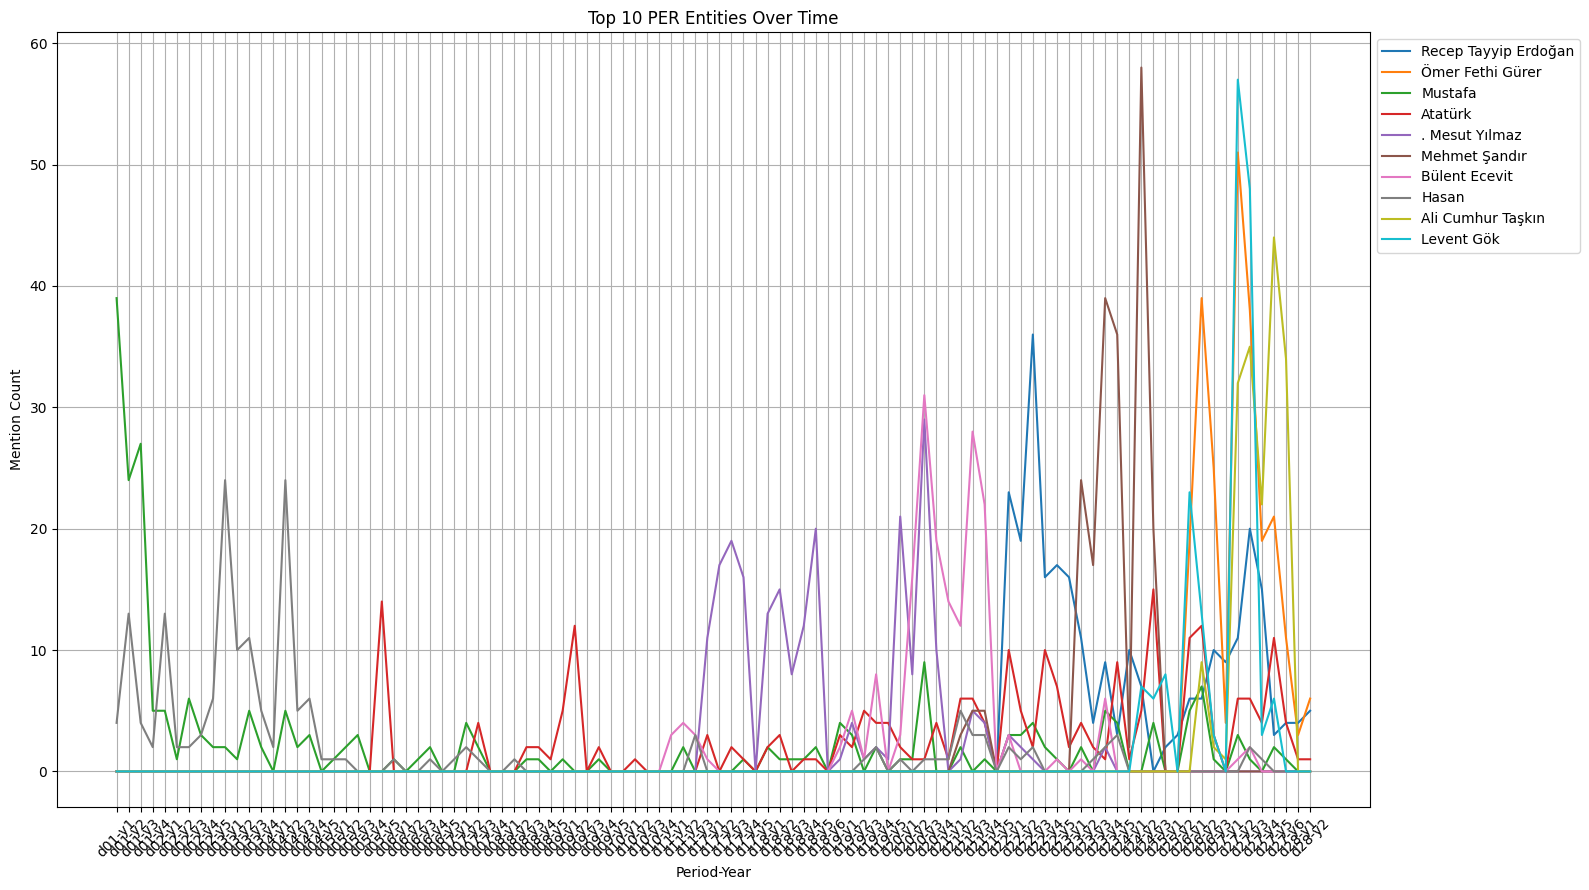

In [42]:

visualize_top_entities_over_time(recombined_entities, top_n=10, entity_type_filter="PER")

In [ ]:
# Traditionally viewed female vs male attribute of persona mentions over time

# Data is from https://github.com/mkozturk/turkishnames/blob/master/turkishnames.zip

def normalize_turkish(name):
    translation_table = str.maketrans({
        'Ç': 'C',
        'Ğ': 'G',
        'İ': 'I',
        'Ö': 'O',
        'Ş': 'S',
        'Ü': 'U'
    })
    return name.upper().translate(translation_table)



def load_name_gender_map(male_file_path, female_file_path=None, min_frequency=100):
    name_gender_map = {}

    # Load male names
    with open(male_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                raw_name, freq = parts[0], int(parts[1])
                name = normalize_turkish(raw_name)
                if freq > min_frequency:
                    name_gender_map[name] = "male"

    # Load female names
    if female_file_path:
        with open(female_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 2:
                    raw_name, freq = parts[0], int(parts[1])
                    name = normalize_turkish(raw_name)
                    if freq > min_frequency:
                        name_gender_map[name] = "female"

    return name_gender_map

# Load dictionary once
name_gender_map = load_name_gender_map("male_name_tally", "female_name_tally")

def predict_gender(name):
    first_name = normalize_turkish(name.split()[0])
    return name_gender_map.get(first_name)


test_names = ["Mehmet", "Ayşe", "Ali", "Fatma", "Kemal", "Elif", "Zeynep"]

for name in test_names:
    gender = predict_gender(name)
    if(gender is None):
        print(f"{name}: Unknown")
    print(f"{name}: {gender}")

Mehmet: male
Ayşe: female
Ali: male
Fatma: female
Kemal: male
Elif: female
Zeynep: female


In [35]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from tqdm import tqdm

def visualize_gender_mentions_over_time(grouped_entities):
    group_names = sorted(grouped_entities.keys())
    data = []

    for group in tqdm(group_names, desc="Processing groups"):
        row = {"group": group, "Male": 0, "Female": 0}

        for ent in grouped_entities[group]:
            if ent.get("entity_group") != "PER":
                continue

            word = ent.get("word", "").strip()
            if len(word) <= 1:
                continue

            gender = predict_gender(word)
            if gender == "male":
                row["Male"] += 1
            elif gender == "female":
                row["Female"] += 1

        data.append(row)

    # Build DataFrame
    df = pd.DataFrame(data).set_index("group").sort_index()

    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df["Male"], label="Male Mentions", color="blue")
    plt.plot(df.index, df["Female"], label="Female Mentions", color="magenta")

    plt.title("Gendered Person Mentions Over Time")
    plt.xlabel("Period-Year")
    plt.ylabel("Number of Mentions")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Processing groups: 100%|██████████| 100/100 [00:00<00:00, 287.62it/s]


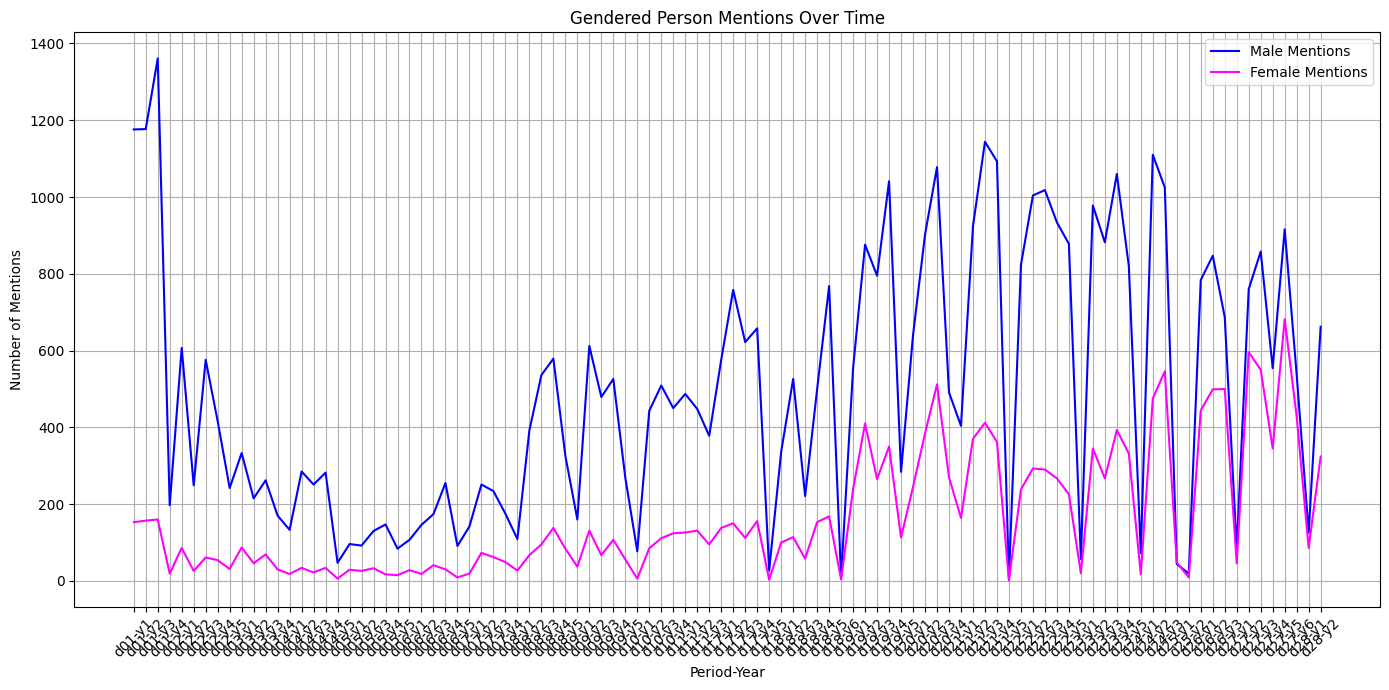

In [38]:
visualize_gender_mentions_over_time(recombined_entities)


📅 All-time Top Entities
     TBMM: 4090
     Meclis: 3224
     Türkiye Büyük Millet Meclisi: 2091
     TÜRKİYE BÜYÜK MİLLET MECLİSİ: 2018
     . B. M. M. B: 1990
     . B. M. M.: 1951
     TBMM Tutanak Hizmetleri Başkanlığı: 1168
     Başbakanlık: 823
     Büyük Millet Meclisi: 800
     . B: 750
     . B. M. M: 716
     Bütçe: 635
     Danışma Kurulu: 549
     Riyaset Divanı: 456
     Adliye: 429
     Plan ve Bütçe Komisyonu: 420
     . B. M. M. ZAB: 398
     TBMM Basımevi: 384
     TBMM Genel Kurulu: 342
     Başkanlık: 319
     Sayıştay Başkanlığı: 319
     . B. M. M. TU: 311
     Adalet Komisyonu: 305
     . B. M. M.AB: 301
     Adliye Encümeni: 296


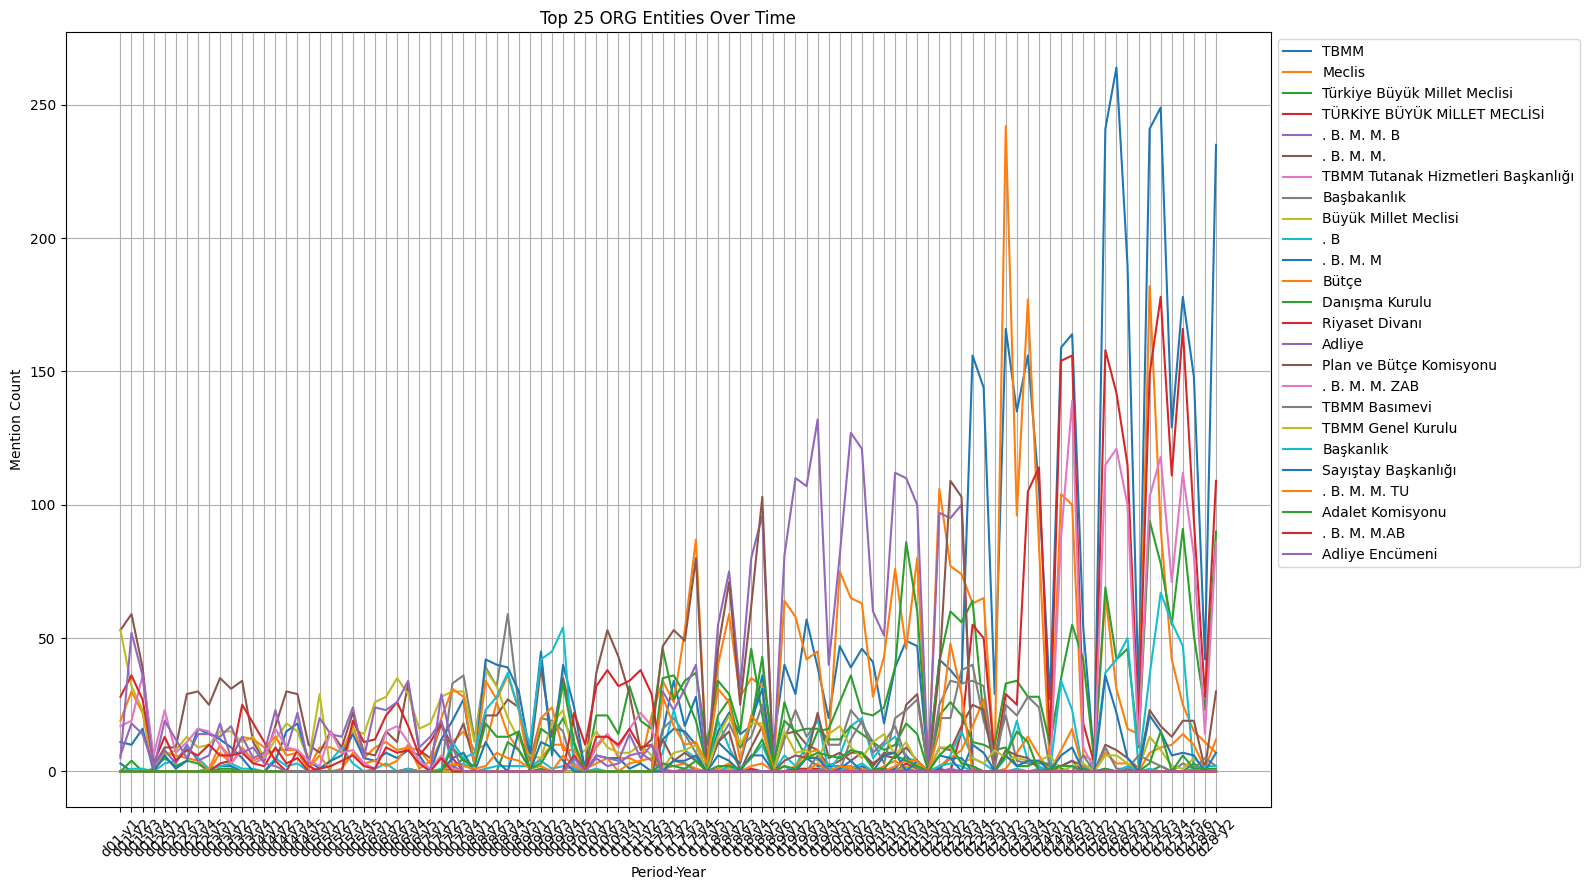

In [45]:

visualize_top_entities_over_time(recombined_entities, top_n=25, entity_type_filter="ORG")

In [49]:
# %pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


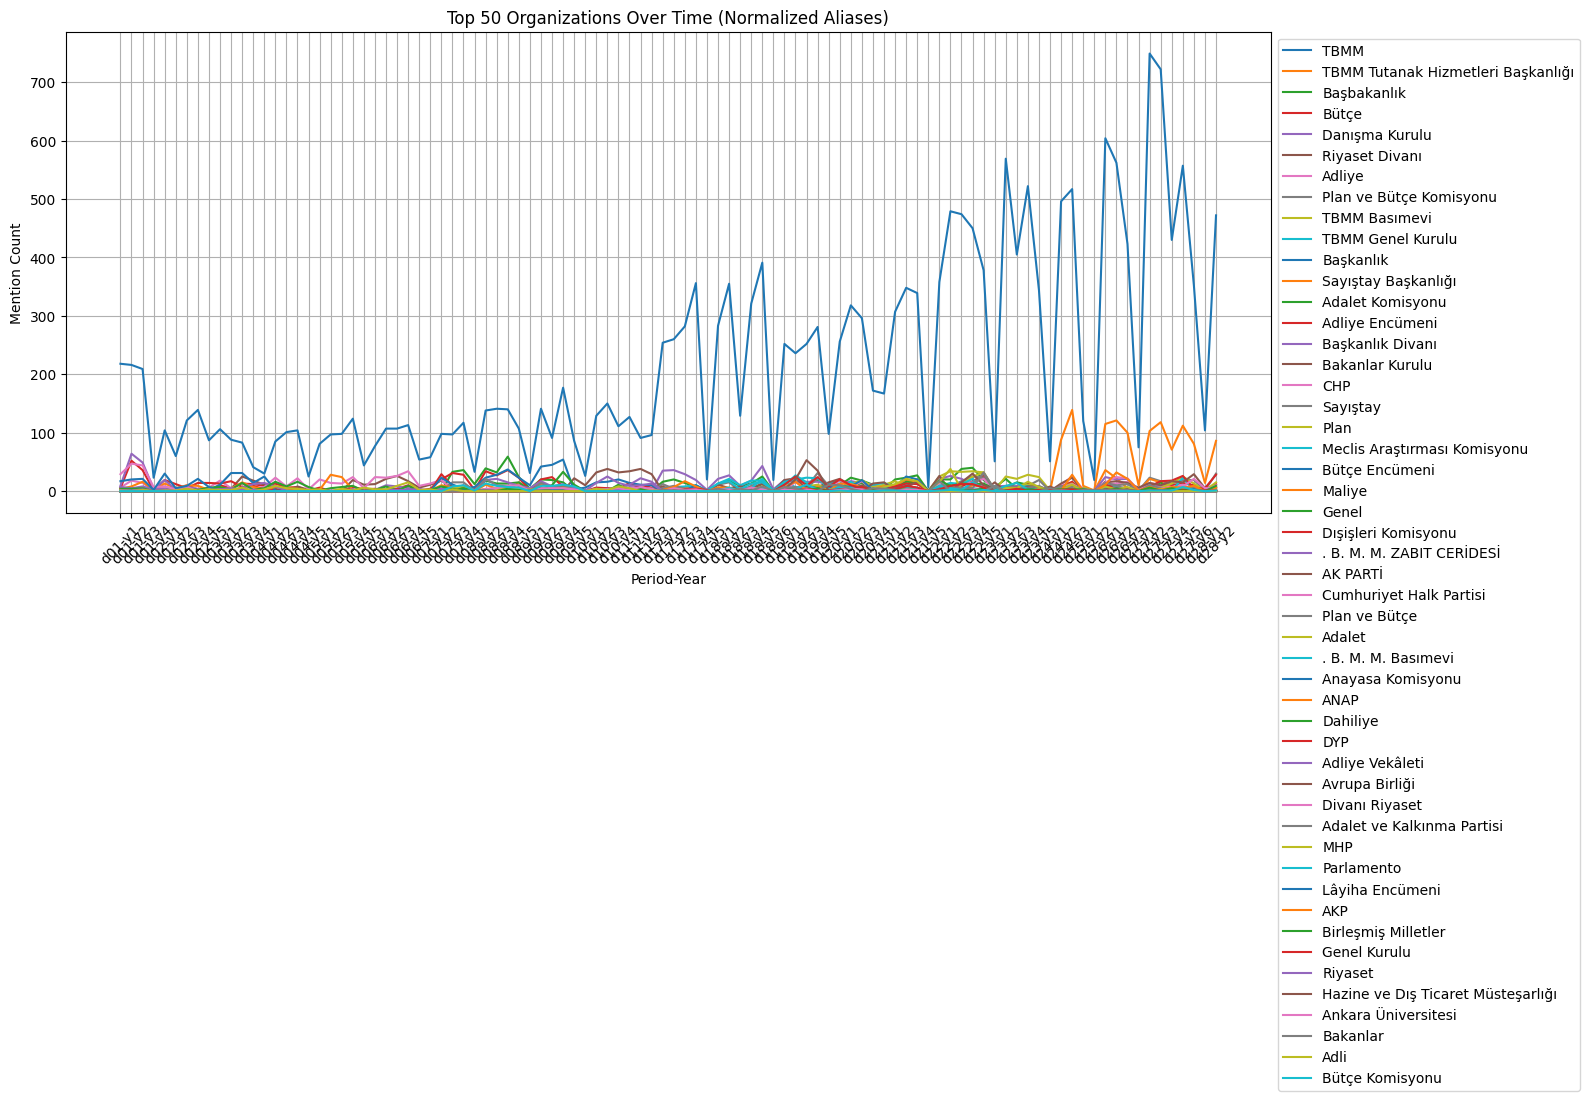

In [53]:
# Too many aliases in organizations, we need to normalize them based on fuzz scores

ORG_ALIASES = {
    # Canonical TBMM forms
    "TBMM": "TBMM",
    "T.B.M.M.": "TBMM",
    ".B.M.M.": "TBMM",
    ". B. M. M.": "TBMM",
    ". B. M. M": "TBMM",
    ". B. M. M. B": "TBMM",
    ". B. M.": "TBMM",
    ". B": "TBMM",
    ". B. M. M. ZAB": "TBMM",
    ". B. M. M. TU": "TBMM",
    "Büyük Millet Meclisi": "TBMM",
    "Türkiye Büyük Millet Meclisi": "TBMM",
    "Meclis": "TBMM",


}

from fuzzywuzzy import fuzz

def normalize_organization_name(name, threshold=85):
    name = name.strip()
    if name in ORG_ALIASES:
        return ORG_ALIASES[name]

    # Fuzzy match against aliases
    best_match = name
    best_score = 0

    for alias, canonical in ORG_ALIASES.items():
        score = fuzz.ratio(name.lower(), alias.lower())
        if score > best_score and score >= threshold:
            best_match = canonical
            best_score = score

    return best_match


# --- Visualization function ---
def visualize_top_organizations_over_time(grouped_entities, top_n=15):
    # Step 1: Aggregate and normalize organization mentions
    overall = Counter()
    
    for group in grouped_entities.values():
        for ent in group:
            if ent.get("entity_group") != "ORG":
                continue
            name = normalize_organization_name(ent.get("word", ""))
            if len(name) > 1:
                overall[name] += 1

    top_orgs = [name for name, _ in overall.most_common(top_n)]

    # Step 2: Build timeseries data
    data = []
    group_names = sorted(grouped_entities.keys())

    for group in group_names:
        row = {"group": group}
        counter = Counter()

        for ent in grouped_entities[group]:
            if ent.get("entity_group") != "ORG":
                continue
            name = normalize_organization_name(ent.get("word", ""))
            if name in top_orgs:
                counter[name] += 1

        for org in top_orgs:
            row[org] = counter[org]

        data.append(row)

    df = pd.DataFrame(data).set_index("group").fillna(0)

    # Step 3: Plot it
    plt.figure(figsize=(16, 9))
    for org in top_orgs:
        plt.plot(df.index, df[org], label=org)

    plt.title(f"Top {top_n} Organizations Over Time (Normalized Aliases)")
    plt.xlabel("Period-Year")
    plt.ylabel("Mention Count")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    plt.show()

visualize_top_organizations_over_time(recombined_entities, top_n=50)


📅 All-time Top Entities
     İstanbul: 5441
     Ankara: 3102
     Türkiye: 2367
     İzmir: 2348
     Konya: 1776
     Bursa: 1626
     Adana: 1564
     Mersin: 1558
     Erzurum: 1297
     Kocaeli: 1132


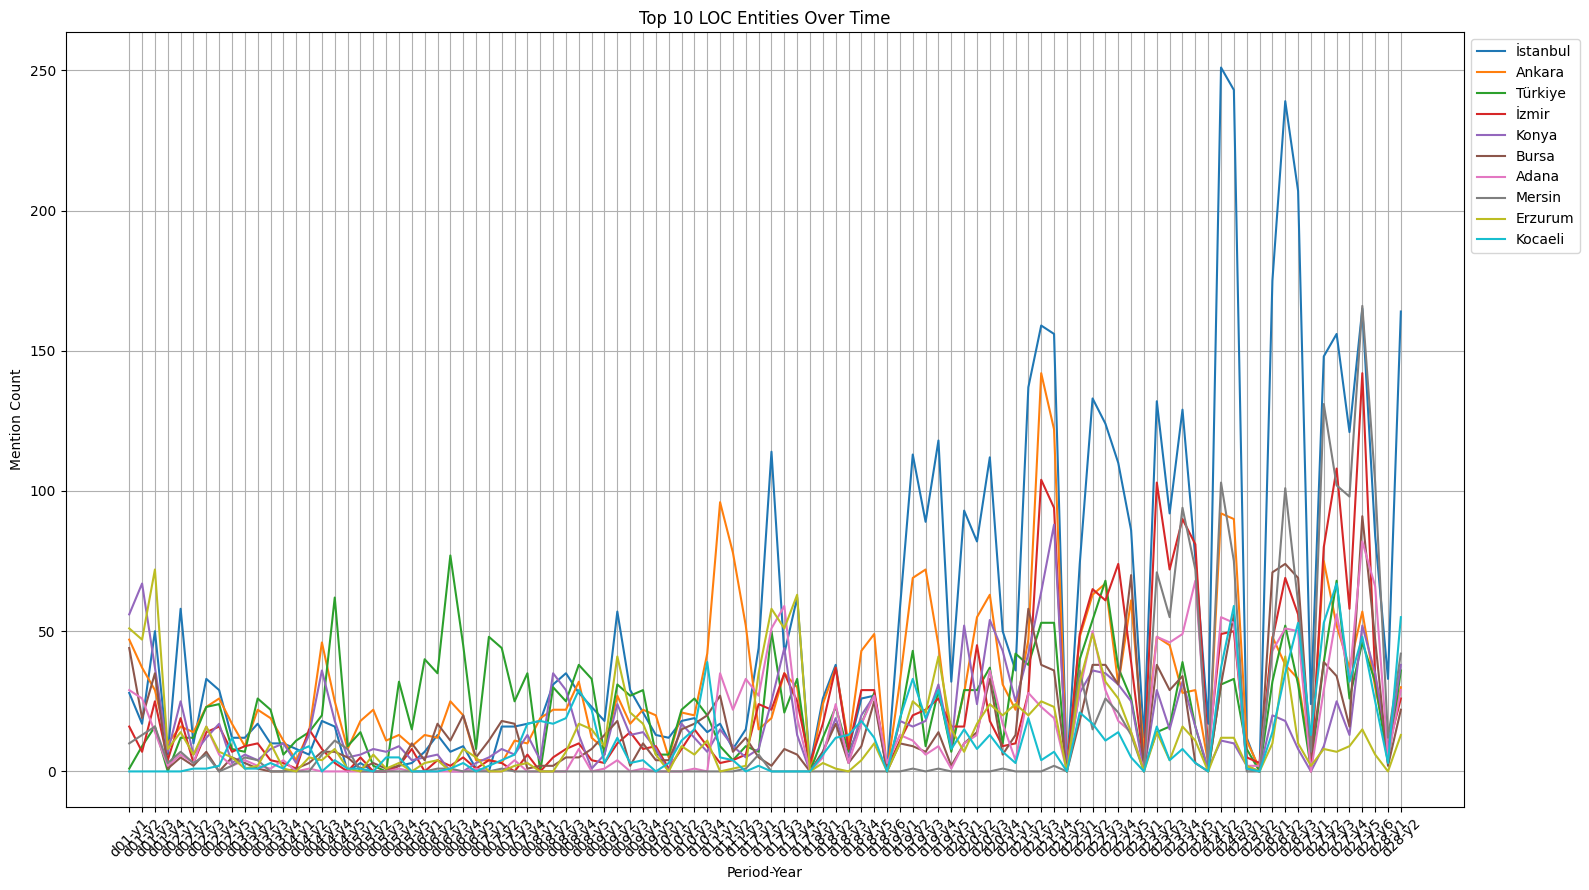

In [44]:
visualize_top_entities_over_time(recombined_entities, top_n=10, entity_type_filter="LOC")